In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf

from torch.autograd import Variable
from torchvision.models import resnet18

from tensorflow import keras
from keras.preprocessing import image

import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

torch.manual_seed(777)

In [6]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
tb = TensorBoardColab()

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3859 sha256=596087ee165b71083dc76fa2f0c2859895299b4f53666cf8bbe6dd59fbba0e33
  Stored in directory: /home/jun/.cache/pip/wheels/e5/6b/92/99a181b543b45a45df4346bcdf01aac1f882fe447c63302878
Successfully built tensorboardcolab
Wait for 8 seconds...
Initialization failed, retry again (1)


Wait for 8 seconds...
Initialization failed, retry again (2)


Wait for 8 seconds...
Initialization failed, retry again (3)


Wait for 8 seconds...


KeyboardInterrupt: 

In [7]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=6, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [8]:
class EmbedNet(nn.Module):
    def __init__(self, base_model, net_vlad):
        super(EmbedNet, self).__init__()
        self.base_model = base_model
        self.net_vlad = net_vlad

    def forward(self, x):
        x = self.base_model(x)
        embedded_x = self.net_vlad(x)
        return embedded_x
      
class TripletNet(nn.Module):
    def __init__(self, embed_net):
        super(TripletNet, self).__init__()
        self.embed_net = embed_net

    def forward(self, a, p, n):
        embedded_a = self.embed_net(a)
        embedded_p = self.embed_net(p)
        embedded_n = self.embed_net(n)
        return embedded_a, embedded_p, embedded_n

    def feature_extract(self, x):
        return self.embed_net(x)

In [9]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.1)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (~i_equal_k)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

In [10]:
# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4,
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=6, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jun/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [11]:
# Define loss
criterion = HardTripletLoss(margin=0.1).cuda()
epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [13]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),               
    torchvision.transforms.ToTensor()
    
])

bef_train_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/Sejong/train', transform=transforms)
bef_train_data_loader = torch.utils.data.DataLoader(bef_train_imagenet_data,
                                          batch_size=776,
                                          shuffle=False,
                                          num_workers=0)

In [14]:
for bef_train_image,bef_train_label in bef_train_data_loader :
  bef_train_image = bef_train_image
  bef_train_label = bef_train_label

In [16]:
train_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/Sejong/train', transform=transforms)
train_data_loader = torch.utils.data.DataLoader(train_imagenet_data,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=0)
test_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/Sejong/test', transform=transforms)
test_data_loader = torch.utils.data.DataLoader(test_imagenet_data,
                                          shuffle=False,
                                          batch_size=100,
                                          num_workers=0)

In [18]:
globaliter = 0

for epoch in range(epochs):
  for batch_idx, (train_image,train_label) in enumerate(train_data_loader) :
    output_train = model(train_image.cuda())
    triplet_loss = criterion(output_train, train_label.cuda())
    optimizer.zero_grad()
    triplet_loss.backward(retain_graph=True)
    optimizer.step()
    # This is where I'm recording to Tensorboard
    # tb.save_value('Train Loss', 'train_loss', globaliter, triplet_loss.item())
    print('epoch : {}, globaliter : {}, batch_idx  : {}, triplet_loss : {}'.format(epoch,globaliter,batch_idx,triplet_loss.item()))
    globaliter += 1
  model_save_name = 'model_{:02d}.pt'.format(epoch)
  path = F"./{model_save_name}" 
  torch.save(model.state_dict(), path)

epoch : 0, globaliter : 0, batch_idx  : 0, triplet_loss : 0.09533710032701492
epoch : 0, globaliter : 1, batch_idx  : 1, triplet_loss : 0.0972115695476532
epoch : 0, globaliter : 2, batch_idx  : 2, triplet_loss : 0.09873875230550766
epoch : 0, globaliter : 3, batch_idx  : 3, triplet_loss : 0.09449876844882965
epoch : 0, globaliter : 4, batch_idx  : 4, triplet_loss : 0.09846276789903641
epoch : 0, globaliter : 5, batch_idx  : 5, triplet_loss : 0.09891442954540253
epoch : 0, globaliter : 6, batch_idx  : 6, triplet_loss : 0.10038081556558609
epoch : 0, globaliter : 7, batch_idx  : 7, triplet_loss : 0.09571786224842072
epoch : 0, globaliter : 8, batch_idx  : 8, triplet_loss : 0.09475719183683395
epoch : 0, globaliter : 9, batch_idx  : 9, triplet_loss : 0.09690630435943604
epoch : 0, globaliter : 10, batch_idx  : 10, triplet_loss : 0.09490952640771866
epoch : 0, globaliter : 11, batch_idx  : 11, triplet_loss : 0.09558792412281036
epoch : 0, globaliter : 12, batch_idx  : 12, triplet_loss : 0

epoch : 1, globaliter : 104, batch_idx  : 7, triplet_loss : 0.0921471118927002
epoch : 1, globaliter : 105, batch_idx  : 8, triplet_loss : 0.09595789760351181
epoch : 1, globaliter : 106, batch_idx  : 9, triplet_loss : 0.09637318551540375
epoch : 1, globaliter : 107, batch_idx  : 10, triplet_loss : 0.0942467600107193
epoch : 1, globaliter : 108, batch_idx  : 11, triplet_loss : 0.09537360072135925
epoch : 1, globaliter : 109, batch_idx  : 12, triplet_loss : 0.0987105593085289
epoch : 1, globaliter : 110, batch_idx  : 13, triplet_loss : 0.09139969199895859
epoch : 1, globaliter : 111, batch_idx  : 14, triplet_loss : 0.09793879091739655
epoch : 1, globaliter : 112, batch_idx  : 15, triplet_loss : 0.09498963505029678
epoch : 1, globaliter : 113, batch_idx  : 16, triplet_loss : 0.09572599828243256
epoch : 1, globaliter : 114, batch_idx  : 17, triplet_loss : 0.0983891636133194
epoch : 1, globaliter : 115, batch_idx  : 18, triplet_loss : 0.09297829121351242
epoch : 1, globaliter : 116, batch_

epoch : 2, globaliter : 206, batch_idx  : 12, triplet_loss : 0.09054406732320786
epoch : 2, globaliter : 207, batch_idx  : 13, triplet_loss : 0.08128942549228668
epoch : 2, globaliter : 208, batch_idx  : 14, triplet_loss : 0.08576599508523941
epoch : 2, globaliter : 209, batch_idx  : 15, triplet_loss : 0.09710421413183212
epoch : 2, globaliter : 210, batch_idx  : 16, triplet_loss : 0.08963194489479065
epoch : 2, globaliter : 211, batch_idx  : 17, triplet_loss : 0.09057408571243286
epoch : 2, globaliter : 212, batch_idx  : 18, triplet_loss : 0.0947209820151329
epoch : 2, globaliter : 213, batch_idx  : 19, triplet_loss : 0.08942805975675583
epoch : 2, globaliter : 214, batch_idx  : 20, triplet_loss : 0.08713967353105545
epoch : 2, globaliter : 215, batch_idx  : 21, triplet_loss : 0.09174700826406479
epoch : 2, globaliter : 216, batch_idx  : 22, triplet_loss : 0.0845431536436081
epoch : 2, globaliter : 217, batch_idx  : 23, triplet_loss : 0.09217395633459091
epoch : 2, globaliter : 218, b

epoch : 3, globaliter : 308, batch_idx  : 17, triplet_loss : 0.08077944815158844
epoch : 3, globaliter : 309, batch_idx  : 18, triplet_loss : 0.0816023200750351
epoch : 3, globaliter : 310, batch_idx  : 19, triplet_loss : 0.07125972956418991
epoch : 3, globaliter : 311, batch_idx  : 20, triplet_loss : 0.07269816845655441
epoch : 3, globaliter : 312, batch_idx  : 21, triplet_loss : 0.08777869492769241
epoch : 3, globaliter : 313, batch_idx  : 22, triplet_loss : 0.08335179835557938
epoch : 3, globaliter : 314, batch_idx  : 23, triplet_loss : 0.09178964048624039
epoch : 3, globaliter : 315, batch_idx  : 24, triplet_loss : 0.06667505949735641
epoch : 3, globaliter : 316, batch_idx  : 25, triplet_loss : 0.07558264583349228
epoch : 3, globaliter : 317, batch_idx  : 26, triplet_loss : 0.07287748903036118
epoch : 3, globaliter : 318, batch_idx  : 27, triplet_loss : 0.07931621372699738
epoch : 3, globaliter : 319, batch_idx  : 28, triplet_loss : 0.08831404149532318
epoch : 3, globaliter : 320, 

epoch : 4, globaliter : 410, batch_idx  : 22, triplet_loss : 0.05535103753209114
epoch : 4, globaliter : 411, batch_idx  : 23, triplet_loss : 0.062289945781230927
epoch : 4, globaliter : 412, batch_idx  : 24, triplet_loss : 0.0759454295039177
epoch : 4, globaliter : 413, batch_idx  : 25, triplet_loss : 0.05758174881339073
epoch : 4, globaliter : 414, batch_idx  : 26, triplet_loss : 0.07104230672121048
epoch : 4, globaliter : 415, batch_idx  : 27, triplet_loss : 0.07260254770517349
epoch : 4, globaliter : 416, batch_idx  : 28, triplet_loss : 0.06643020361661911
epoch : 4, globaliter : 417, batch_idx  : 29, triplet_loss : 0.050178151577711105
epoch : 4, globaliter : 418, batch_idx  : 30, triplet_loss : 0.06375527381896973
epoch : 4, globaliter : 419, batch_idx  : 31, triplet_loss : 0.04942589998245239
epoch : 4, globaliter : 420, batch_idx  : 32, triplet_loss : 0.06269719451665878
epoch : 4, globaliter : 421, batch_idx  : 33, triplet_loss : 0.0846925601363182
epoch : 4, globaliter : 422,

epoch : 5, globaliter : 512, batch_idx  : 27, triplet_loss : 0.05772741138935089
epoch : 5, globaliter : 513, batch_idx  : 28, triplet_loss : 0.04991545155644417
epoch : 5, globaliter : 514, batch_idx  : 29, triplet_loss : 0.05665040388703346
epoch : 5, globaliter : 515, batch_idx  : 30, triplet_loss : 0.05730128288269043
epoch : 5, globaliter : 516, batch_idx  : 31, triplet_loss : 0.07562214136123657
epoch : 5, globaliter : 517, batch_idx  : 32, triplet_loss : 0.03218835964798927
epoch : 5, globaliter : 518, batch_idx  : 33, triplet_loss : 0.05347398295998573
epoch : 5, globaliter : 519, batch_idx  : 34, triplet_loss : 0.06788671016693115
epoch : 5, globaliter : 520, batch_idx  : 35, triplet_loss : 0.04879602789878845
epoch : 5, globaliter : 521, batch_idx  : 36, triplet_loss : 0.03015773370862007
epoch : 5, globaliter : 522, batch_idx  : 37, triplet_loss : 0.044152695685625076
epoch : 5, globaliter : 523, batch_idx  : 38, triplet_loss : 0.08627551048994064
epoch : 5, globaliter : 524

epoch : 6, globaliter : 614, batch_idx  : 32, triplet_loss : 0.06171439588069916
epoch : 6, globaliter : 615, batch_idx  : 33, triplet_loss : 0.030702464282512665
epoch : 6, globaliter : 616, batch_idx  : 34, triplet_loss : 0.043075889348983765
epoch : 6, globaliter : 617, batch_idx  : 35, triplet_loss : 0.05060536786913872
epoch : 6, globaliter : 618, batch_idx  : 36, triplet_loss : 0.04221181571483612
epoch : 6, globaliter : 619, batch_idx  : 37, triplet_loss : 0.05023464187979698
epoch : 6, globaliter : 620, batch_idx  : 38, triplet_loss : 0.03335510939359665
epoch : 6, globaliter : 621, batch_idx  : 39, triplet_loss : 0.039983391761779785
epoch : 6, globaliter : 622, batch_idx  : 40, triplet_loss : 0.06014257296919823
epoch : 6, globaliter : 623, batch_idx  : 41, triplet_loss : 0.049999840557575226
epoch : 6, globaliter : 624, batch_idx  : 42, triplet_loss : 0.045781321823596954
epoch : 6, globaliter : 625, batch_idx  : 43, triplet_loss : 0.04790819063782692
epoch : 6, globaliter :

epoch : 7, globaliter : 715, batch_idx  : 36, triplet_loss : 0.060254938900470734
epoch : 7, globaliter : 716, batch_idx  : 37, triplet_loss : 0.018950041383504868
epoch : 7, globaliter : 717, batch_idx  : 38, triplet_loss : 0.020425084978342056
epoch : 7, globaliter : 718, batch_idx  : 39, triplet_loss : 0.023157594725489616
epoch : 7, globaliter : 719, batch_idx  : 40, triplet_loss : 0.019337737932801247
epoch : 7, globaliter : 720, batch_idx  : 41, triplet_loss : 0.059050481766462326
epoch : 7, globaliter : 721, batch_idx  : 42, triplet_loss : 0.014212654903531075
epoch : 7, globaliter : 722, batch_idx  : 43, triplet_loss : 0.07422497123479843
epoch : 7, globaliter : 723, batch_idx  : 44, triplet_loss : 0.0563056506216526
epoch : 7, globaliter : 724, batch_idx  : 45, triplet_loss : 0.0340094268321991
epoch : 7, globaliter : 725, batch_idx  : 46, triplet_loss : 0.026331238448619843
epoch : 7, globaliter : 726, batch_idx  : 47, triplet_loss : 0.05875471606850624
epoch : 7, globaliter 

epoch : 8, globaliter : 816, batch_idx  : 40, triplet_loss : 0.012810999527573586
epoch : 8, globaliter : 817, batch_idx  : 41, triplet_loss : 0.06190870702266693
epoch : 8, globaliter : 818, batch_idx  : 42, triplet_loss : 0.031239960342645645
epoch : 8, globaliter : 819, batch_idx  : 43, triplet_loss : 0.025978313758969307
epoch : 8, globaliter : 820, batch_idx  : 44, triplet_loss : 0.014139044098556042
epoch : 8, globaliter : 821, batch_idx  : 45, triplet_loss : 0.025969170033931732
epoch : 8, globaliter : 822, batch_idx  : 46, triplet_loss : 0.03707653284072876
epoch : 8, globaliter : 823, batch_idx  : 47, triplet_loss : 0.0852401852607727
epoch : 8, globaliter : 824, batch_idx  : 48, triplet_loss : 0.031494226306676865
epoch : 8, globaliter : 825, batch_idx  : 49, triplet_loss : 0.030214840546250343
epoch : 8, globaliter : 826, batch_idx  : 50, triplet_loss : 0.022750047966837883
epoch : 8, globaliter : 827, batch_idx  : 51, triplet_loss : 0.04142696410417557
epoch : 8, globaliter

epoch : 9, globaliter : 917, batch_idx  : 44, triplet_loss : 0.03564910218119621
epoch : 9, globaliter : 918, batch_idx  : 45, triplet_loss : 0.03952767327427864
epoch : 9, globaliter : 919, batch_idx  : 46, triplet_loss : 0.011510413140058517
epoch : 9, globaliter : 920, batch_idx  : 47, triplet_loss : 0.03820716589689255
epoch : 9, globaliter : 921, batch_idx  : 48, triplet_loss : 0.06704462319612503
epoch : 9, globaliter : 922, batch_idx  : 49, triplet_loss : 0.04041311517357826
epoch : 9, globaliter : 923, batch_idx  : 50, triplet_loss : 0.03957931697368622
epoch : 9, globaliter : 924, batch_idx  : 51, triplet_loss : 0.032701220363378525
epoch : 9, globaliter : 925, batch_idx  : 52, triplet_loss : 0.027485810220241547
epoch : 9, globaliter : 926, batch_idx  : 53, triplet_loss : 0.041128531098365784
epoch : 9, globaliter : 927, batch_idx  : 54, triplet_loss : 0.023315569385886192
epoch : 9, globaliter : 928, batch_idx  : 55, triplet_loss : 0.01646116003394127
epoch : 9, globaliter :

epoch : 10, globaliter : 1017, batch_idx  : 47, triplet_loss : 0.015523113310337067
epoch : 10, globaliter : 1018, batch_idx  : 48, triplet_loss : 0.008872180245816708
epoch : 10, globaliter : 1019, batch_idx  : 49, triplet_loss : 0.04725652188062668
epoch : 10, globaliter : 1020, batch_idx  : 50, triplet_loss : 0.030992865562438965
epoch : 10, globaliter : 1021, batch_idx  : 51, triplet_loss : 0.029525240883231163
epoch : 10, globaliter : 1022, batch_idx  : 52, triplet_loss : 0.022996731102466583
epoch : 10, globaliter : 1023, batch_idx  : 53, triplet_loss : 0.011438515968620777
epoch : 10, globaliter : 1024, batch_idx  : 54, triplet_loss : 0.06966366618871689
epoch : 10, globaliter : 1025, batch_idx  : 55, triplet_loss : 0.0232210922986269
epoch : 10, globaliter : 1026, batch_idx  : 56, triplet_loss : 0.04069601371884346
epoch : 10, globaliter : 1027, batch_idx  : 57, triplet_loss : 0.02081717923283577
epoch : 10, globaliter : 1028, batch_idx  : 58, triplet_loss : 0.07013896852731705

epoch : 11, globaliter : 1116, batch_idx  : 49, triplet_loss : 0.04429938644170761
epoch : 11, globaliter : 1117, batch_idx  : 50, triplet_loss : 0.012453995645046234
epoch : 11, globaliter : 1118, batch_idx  : 51, triplet_loss : 0.019532745704054832
epoch : 11, globaliter : 1119, batch_idx  : 52, triplet_loss : 0.006480839569121599
epoch : 11, globaliter : 1120, batch_idx  : 53, triplet_loss : 0.04704020917415619
epoch : 11, globaliter : 1121, batch_idx  : 54, triplet_loss : 0.005597904324531555
epoch : 11, globaliter : 1122, batch_idx  : 55, triplet_loss : 0.019253889098763466
epoch : 11, globaliter : 1123, batch_idx  : 56, triplet_loss : 0.006793277338147163
epoch : 11, globaliter : 1124, batch_idx  : 57, triplet_loss : 0.026013363152742386
epoch : 11, globaliter : 1125, batch_idx  : 58, triplet_loss : 0.017502762377262115
epoch : 11, globaliter : 1126, batch_idx  : 59, triplet_loss : 0.024637272581458092
epoch : 11, globaliter : 1127, batch_idx  : 60, triplet_loss : 0.0169561635702

epoch : 12, globaliter : 1215, batch_idx  : 51, triplet_loss : 0.015086977742612362
epoch : 12, globaliter : 1216, batch_idx  : 52, triplet_loss : 0.015492451377213001
epoch : 12, globaliter : 1217, batch_idx  : 53, triplet_loss : 0.031134719029068947
epoch : 12, globaliter : 1218, batch_idx  : 54, triplet_loss : 0.009487738832831383
epoch : 12, globaliter : 1219, batch_idx  : 55, triplet_loss : 0.006385682616382837
epoch : 12, globaliter : 1220, batch_idx  : 56, triplet_loss : 0.020218228921294212
epoch : 12, globaliter : 1221, batch_idx  : 57, triplet_loss : 0.01356187928467989
epoch : 12, globaliter : 1222, batch_idx  : 58, triplet_loss : 0.04019339755177498
epoch : 12, globaliter : 1223, batch_idx  : 59, triplet_loss : 0.01867988333106041
epoch : 12, globaliter : 1224, batch_idx  : 60, triplet_loss : 0.01223576907068491
epoch : 12, globaliter : 1225, batch_idx  : 61, triplet_loss : 0.024260273203253746
epoch : 12, globaliter : 1226, batch_idx  : 62, triplet_loss : 0.018102876842021

epoch : 13, globaliter : 1314, batch_idx  : 53, triplet_loss : 0.020356575027108192
epoch : 13, globaliter : 1315, batch_idx  : 54, triplet_loss : 0.015012726187705994
epoch : 13, globaliter : 1316, batch_idx  : 55, triplet_loss : 0.0204317606985569
epoch : 13, globaliter : 1317, batch_idx  : 56, triplet_loss : 0.041365452110767365
epoch : 13, globaliter : 1318, batch_idx  : 57, triplet_loss : 0.021526113152503967
epoch : 13, globaliter : 1319, batch_idx  : 58, triplet_loss : 0.008370722644031048
epoch : 13, globaliter : 1320, batch_idx  : 59, triplet_loss : 0.009391430765390396
epoch : 13, globaliter : 1321, batch_idx  : 60, triplet_loss : 0.03837329521775246
epoch : 13, globaliter : 1322, batch_idx  : 61, triplet_loss : 0.008444464765489101
epoch : 13, globaliter : 1323, batch_idx  : 62, triplet_loss : 0.016039825975894928
epoch : 13, globaliter : 1324, batch_idx  : 63, triplet_loss : 0.006128262262791395
epoch : 13, globaliter : 1325, batch_idx  : 64, triplet_loss : 0.01631836220622

epoch : 14, globaliter : 1413, batch_idx  : 55, triplet_loss : 0.01090848259627819
epoch : 14, globaliter : 1414, batch_idx  : 56, triplet_loss : 0.008238659240305424
epoch : 14, globaliter : 1415, batch_idx  : 57, triplet_loss : 0.016715215519070625
epoch : 14, globaliter : 1416, batch_idx  : 58, triplet_loss : 0.020138787105679512
epoch : 14, globaliter : 1417, batch_idx  : 59, triplet_loss : 0.022020824253559113
epoch : 14, globaliter : 1418, batch_idx  : 60, triplet_loss : 0.0033679744228720665
epoch : 14, globaliter : 1419, batch_idx  : 61, triplet_loss : 0.010335848666727543
epoch : 14, globaliter : 1420, batch_idx  : 62, triplet_loss : 0.06639929860830307
epoch : 14, globaliter : 1421, batch_idx  : 63, triplet_loss : 0.013939231634140015
epoch : 14, globaliter : 1422, batch_idx  : 64, triplet_loss : 0.0016826801002025604
epoch : 14, globaliter : 1423, batch_idx  : 65, triplet_loss : 0.01727467216551304
epoch : 14, globaliter : 1424, batch_idx  : 66, triplet_loss : 0.015285334549

epoch : 15, globaliter : 1512, batch_idx  : 57, triplet_loss : 0.0479094460606575
epoch : 15, globaliter : 1513, batch_idx  : 58, triplet_loss : 0.05383450537919998
epoch : 15, globaliter : 1514, batch_idx  : 59, triplet_loss : 0.03184930607676506
epoch : 15, globaliter : 1515, batch_idx  : 60, triplet_loss : 0.030888905748724937
epoch : 15, globaliter : 1516, batch_idx  : 61, triplet_loss : 0.03527902811765671
epoch : 15, globaliter : 1517, batch_idx  : 62, triplet_loss : 0.03169550374150276
epoch : 15, globaliter : 1518, batch_idx  : 63, triplet_loss : 0.029719434678554535
epoch : 15, globaliter : 1519, batch_idx  : 64, triplet_loss : 0.0
epoch : 15, globaliter : 1520, batch_idx  : 65, triplet_loss : 0.029668772593140602
epoch : 15, globaliter : 1521, batch_idx  : 66, triplet_loss : 0.0410865917801857
epoch : 15, globaliter : 1522, batch_idx  : 67, triplet_loss : 0.04369676485657692
epoch : 15, globaliter : 1523, batch_idx  : 68, triplet_loss : 0.03797347843647003
epoch : 15, globali

epoch : 16, globaliter : 1611, batch_idx  : 59, triplet_loss : 0.049415286630392075
epoch : 16, globaliter : 1612, batch_idx  : 60, triplet_loss : 0.03279121220111847
epoch : 16, globaliter : 1613, batch_idx  : 61, triplet_loss : 0.016232427209615707
epoch : 16, globaliter : 1614, batch_idx  : 62, triplet_loss : 0.009954703971743584
epoch : 16, globaliter : 1615, batch_idx  : 63, triplet_loss : 0.013232909142971039
epoch : 16, globaliter : 1616, batch_idx  : 64, triplet_loss : 0.08570186048746109
epoch : 16, globaliter : 1617, batch_idx  : 65, triplet_loss : 0.022206049412488937
epoch : 16, globaliter : 1618, batch_idx  : 66, triplet_loss : 0.0019498566398397088
epoch : 16, globaliter : 1619, batch_idx  : 67, triplet_loss : 0.002775125205516815
epoch : 16, globaliter : 1620, batch_idx  : 68, triplet_loss : 0.02050885371863842
epoch : 16, globaliter : 1621, batch_idx  : 69, triplet_loss : 0.02193388342857361
epoch : 16, globaliter : 1622, batch_idx  : 70, triplet_loss : 0.01354020554572

epoch : 17, globaliter : 1710, batch_idx  : 61, triplet_loss : 0.0187664907425642
epoch : 17, globaliter : 1711, batch_idx  : 62, triplet_loss : 0.0202773604542017
epoch : 17, globaliter : 1712, batch_idx  : 63, triplet_loss : 0.006131989415735006
epoch : 17, globaliter : 1713, batch_idx  : 64, triplet_loss : 0.013456960208714008
epoch : 17, globaliter : 1714, batch_idx  : 65, triplet_loss : 0.02712882310152054
epoch : 17, globaliter : 1715, batch_idx  : 66, triplet_loss : 0.01847986690700054
epoch : 17, globaliter : 1716, batch_idx  : 67, triplet_loss : 0.015966644510626793
epoch : 17, globaliter : 1717, batch_idx  : 68, triplet_loss : 0.031282830983400345
epoch : 17, globaliter : 1718, batch_idx  : 69, triplet_loss : 0.013729936443269253
epoch : 17, globaliter : 1719, batch_idx  : 70, triplet_loss : 0.02154657244682312
epoch : 17, globaliter : 1720, batch_idx  : 71, triplet_loss : 0.039382148534059525
epoch : 17, globaliter : 1721, batch_idx  : 72, triplet_loss : 0.023214487358927727

epoch : 18, globaliter : 1809, batch_idx  : 63, triplet_loss : 0.0398179367184639
epoch : 18, globaliter : 1810, batch_idx  : 64, triplet_loss : 0.03345104679465294
epoch : 18, globaliter : 1811, batch_idx  : 65, triplet_loss : 0.016711248084902763
epoch : 18, globaliter : 1812, batch_idx  : 66, triplet_loss : 0.0019297286635264754
epoch : 18, globaliter : 1813, batch_idx  : 67, triplet_loss : 0.03801114112138748
epoch : 18, globaliter : 1814, batch_idx  : 68, triplet_loss : 0.016677038744091988
epoch : 18, globaliter : 1815, batch_idx  : 69, triplet_loss : 0.0042341784574091434
epoch : 18, globaliter : 1816, batch_idx  : 70, triplet_loss : 0.007171829231083393
epoch : 18, globaliter : 1817, batch_idx  : 71, triplet_loss : 0.002930196700617671
epoch : 18, globaliter : 1818, batch_idx  : 72, triplet_loss : 0.04483068361878395
epoch : 18, globaliter : 1819, batch_idx  : 73, triplet_loss : 0.008469507098197937
epoch : 18, globaliter : 1820, batch_idx  : 74, triplet_loss : 0.01522458530962

epoch : 19, globaliter : 1908, batch_idx  : 65, triplet_loss : 0.0035145829897373915
epoch : 19, globaliter : 1909, batch_idx  : 66, triplet_loss : 0.017316626384854317
epoch : 19, globaliter : 1910, batch_idx  : 67, triplet_loss : 0.026299357414245605
epoch : 19, globaliter : 1911, batch_idx  : 68, triplet_loss : 0.012917038053274155
epoch : 19, globaliter : 1912, batch_idx  : 69, triplet_loss : 0.02590978518128395
epoch : 19, globaliter : 1913, batch_idx  : 70, triplet_loss : 0.02740825153887272
epoch : 19, globaliter : 1914, batch_idx  : 71, triplet_loss : 0.013100502081215382
epoch : 19, globaliter : 1915, batch_idx  : 72, triplet_loss : 0.0024914490059018135
epoch : 19, globaliter : 1916, batch_idx  : 73, triplet_loss : 0.01856570690870285
epoch : 19, globaliter : 1917, batch_idx  : 74, triplet_loss : 0.02010437659919262
epoch : 19, globaliter : 1918, batch_idx  : 75, triplet_loss : 0.014013614505529404
epoch : 19, globaliter : 1919, batch_idx  : 76, triplet_loss : 0.0480871126055

epoch : 20, globaliter : 2008, batch_idx  : 68, triplet_loss : 0.009959456510841846
epoch : 20, globaliter : 2009, batch_idx  : 69, triplet_loss : 0.011997921392321587
epoch : 20, globaliter : 2010, batch_idx  : 70, triplet_loss : 0.015190064907073975
epoch : 20, globaliter : 2011, batch_idx  : 71, triplet_loss : 0.008632508106529713
epoch : 20, globaliter : 2012, batch_idx  : 72, triplet_loss : 0.004069175571203232
epoch : 20, globaliter : 2013, batch_idx  : 73, triplet_loss : 0.027719803154468536
epoch : 20, globaliter : 2014, batch_idx  : 74, triplet_loss : 0.018778780475258827
epoch : 20, globaliter : 2015, batch_idx  : 75, triplet_loss : 0.009363585151731968
epoch : 20, globaliter : 2016, batch_idx  : 76, triplet_loss : 0.01130184531211853
epoch : 20, globaliter : 2017, batch_idx  : 77, triplet_loss : 0.011014685966074467
epoch : 20, globaliter : 2018, batch_idx  : 78, triplet_loss : 0.012020107358694077
epoch : 20, globaliter : 2019, batch_idx  : 79, triplet_loss : 0.007642614655

epoch : 21, globaliter : 2107, batch_idx  : 70, triplet_loss : 0.022066380828619003
epoch : 21, globaliter : 2108, batch_idx  : 71, triplet_loss : 0.011508009396493435
epoch : 21, globaliter : 2109, batch_idx  : 72, triplet_loss : 0.03419741615653038
epoch : 21, globaliter : 2110, batch_idx  : 73, triplet_loss : 0.02030346728861332
epoch : 21, globaliter : 2111, batch_idx  : 74, triplet_loss : 0.00470403116196394
epoch : 21, globaliter : 2112, batch_idx  : 75, triplet_loss : 0.04431980848312378
epoch : 21, globaliter : 2113, batch_idx  : 76, triplet_loss : 0.012928731739521027
epoch : 21, globaliter : 2114, batch_idx  : 77, triplet_loss : 0.005849300418049097
epoch : 21, globaliter : 2115, batch_idx  : 78, triplet_loss : 0.023324882611632347
epoch : 21, globaliter : 2116, batch_idx  : 79, triplet_loss : 0.0
epoch : 21, globaliter : 2117, batch_idx  : 80, triplet_loss : 0.022747371345758438
epoch : 21, globaliter : 2118, batch_idx  : 81, triplet_loss : 0.010114949196577072
epoch : 21, g

epoch : 22, globaliter : 2206, batch_idx  : 72, triplet_loss : 0.011387850157916546
epoch : 22, globaliter : 2207, batch_idx  : 73, triplet_loss : 0.01032093446701765
epoch : 22, globaliter : 2208, batch_idx  : 74, triplet_loss : 0.006981228478252888
epoch : 22, globaliter : 2209, batch_idx  : 75, triplet_loss : 0.01020810566842556
epoch : 22, globaliter : 2210, batch_idx  : 76, triplet_loss : 0.018284950405359268
epoch : 22, globaliter : 2211, batch_idx  : 77, triplet_loss : 0.04312837868928909
epoch : 22, globaliter : 2212, batch_idx  : 78, triplet_loss : 0.0005392566090449691
epoch : 22, globaliter : 2213, batch_idx  : 79, triplet_loss : 0.0066581531427800655
epoch : 22, globaliter : 2214, batch_idx  : 80, triplet_loss : 0.02150353416800499
epoch : 22, globaliter : 2215, batch_idx  : 81, triplet_loss : 0.025547388941049576
epoch : 22, globaliter : 2216, batch_idx  : 82, triplet_loss : 0.019369015470147133
epoch : 22, globaliter : 2217, batch_idx  : 83, triplet_loss : 0.0158566255122

epoch : 23, globaliter : 2306, batch_idx  : 75, triplet_loss : 0.0010380856692790985
epoch : 23, globaliter : 2307, batch_idx  : 76, triplet_loss : 0.008462611585855484
epoch : 23, globaliter : 2308, batch_idx  : 77, triplet_loss : 0.0271320603787899
epoch : 23, globaliter : 2309, batch_idx  : 78, triplet_loss : 0.009407266043126583
epoch : 23, globaliter : 2310, batch_idx  : 79, triplet_loss : 0.01416847389191389
epoch : 23, globaliter : 2311, batch_idx  : 80, triplet_loss : 0.01349013764411211
epoch : 23, globaliter : 2312, batch_idx  : 81, triplet_loss : 0.006608751602470875
epoch : 23, globaliter : 2313, batch_idx  : 82, triplet_loss : 0.005234924610704184
epoch : 23, globaliter : 2314, batch_idx  : 83, triplet_loss : 0.012974729761481285
epoch : 23, globaliter : 2315, batch_idx  : 84, triplet_loss : 0.0133510185405612
epoch : 23, globaliter : 2316, batch_idx  : 85, triplet_loss : 0.015081062912940979
epoch : 23, globaliter : 2317, batch_idx  : 86, triplet_loss : 0.0222752913832664

epoch : 24, globaliter : 2406, batch_idx  : 78, triplet_loss : 0.024051474407315254
epoch : 24, globaliter : 2407, batch_idx  : 79, triplet_loss : 0.008319318294525146
epoch : 24, globaliter : 2408, batch_idx  : 80, triplet_loss : 0.0
epoch : 24, globaliter : 2409, batch_idx  : 81, triplet_loss : 0.018527144566178322
epoch : 24, globaliter : 2410, batch_idx  : 82, triplet_loss : 0.0
epoch : 24, globaliter : 2411, batch_idx  : 83, triplet_loss : 0.022826164960861206
epoch : 24, globaliter : 2412, batch_idx  : 84, triplet_loss : 0.03961225971579552
epoch : 24, globaliter : 2413, batch_idx  : 85, triplet_loss : 0.004719563759863377
epoch : 24, globaliter : 2414, batch_idx  : 86, triplet_loss : 0.006173933856189251
epoch : 24, globaliter : 2415, batch_idx  : 87, triplet_loss : 0.004675325006246567
epoch : 24, globaliter : 2416, batch_idx  : 88, triplet_loss : 0.019114073365926743
epoch : 24, globaliter : 2417, batch_idx  : 89, triplet_loss : 0.013072078116238117
epoch : 24, globaliter : 24

epoch : 25, globaliter : 2506, batch_idx  : 81, triplet_loss : 0.008724012412130833
epoch : 25, globaliter : 2507, batch_idx  : 82, triplet_loss : 0.0242520309984684
epoch : 25, globaliter : 2508, batch_idx  : 83, triplet_loss : 0.00015212595462799072
epoch : 25, globaliter : 2509, batch_idx  : 84, triplet_loss : 0.00814085453748703
epoch : 25, globaliter : 2510, batch_idx  : 85, triplet_loss : 0.036019206047058105
epoch : 25, globaliter : 2511, batch_idx  : 86, triplet_loss : 0.019638508558273315
epoch : 25, globaliter : 2512, batch_idx  : 87, triplet_loss : 0.030821071937680244
epoch : 25, globaliter : 2513, batch_idx  : 88, triplet_loss : 0.00724656879901886
epoch : 25, globaliter : 2514, batch_idx  : 89, triplet_loss : 0.02887013554573059
epoch : 25, globaliter : 2515, batch_idx  : 90, triplet_loss : 0.006039917469024658
epoch : 25, globaliter : 2516, batch_idx  : 91, triplet_loss : 0.012799475342035294
epoch : 25, globaliter : 2517, batch_idx  : 92, triplet_loss : 0.00775426067411

epoch : 26, globaliter : 2605, batch_idx  : 83, triplet_loss : 0.020167972892522812
epoch : 26, globaliter : 2606, batch_idx  : 84, triplet_loss : 0.01217607967555523
epoch : 26, globaliter : 2607, batch_idx  : 85, triplet_loss : 0.03138492628931999
epoch : 26, globaliter : 2608, batch_idx  : 86, triplet_loss : 0.0028185006231069565
epoch : 26, globaliter : 2609, batch_idx  : 87, triplet_loss : 0.0
epoch : 26, globaliter : 2610, batch_idx  : 88, triplet_loss : 0.0057210554368793964
epoch : 26, globaliter : 2611, batch_idx  : 89, triplet_loss : 0.015773622319102287
epoch : 26, globaliter : 2612, batch_idx  : 90, triplet_loss : 0.003307989565655589
epoch : 26, globaliter : 2613, batch_idx  : 91, triplet_loss : 0.017119061201810837
epoch : 26, globaliter : 2614, batch_idx  : 92, triplet_loss : 0.005940128117799759
epoch : 26, globaliter : 2615, batch_idx  : 93, triplet_loss : 0.013180906884372234
epoch : 26, globaliter : 2616, batch_idx  : 94, triplet_loss : 0.02578612044453621
epoch : 26

epoch : 27, globaliter : 2705, batch_idx  : 86, triplet_loss : 0.01666080765426159
epoch : 27, globaliter : 2706, batch_idx  : 87, triplet_loss : 0.002674330025911331
epoch : 27, globaliter : 2707, batch_idx  : 88, triplet_loss : 0.0025343280285596848
epoch : 27, globaliter : 2708, batch_idx  : 89, triplet_loss : 0.008331071585416794
epoch : 27, globaliter : 2709, batch_idx  : 90, triplet_loss : 0.012201901525259018
epoch : 27, globaliter : 2710, batch_idx  : 91, triplet_loss : 0.019684258848428726
epoch : 27, globaliter : 2711, batch_idx  : 92, triplet_loss : 0.00663771852850914
epoch : 27, globaliter : 2712, batch_idx  : 93, triplet_loss : 0.02496199868619442
epoch : 27, globaliter : 2713, batch_idx  : 94, triplet_loss : 0.011314922012388706
epoch : 27, globaliter : 2714, batch_idx  : 95, triplet_loss : 0.030888698995113373
epoch : 27, globaliter : 2715, batch_idx  : 96, triplet_loss : 0.007883586920797825
epoch : 28, globaliter : 2716, batch_idx  : 0, triplet_loss : 0.00685323774814

epoch : 28, globaliter : 2805, batch_idx  : 89, triplet_loss : 0.009373888373374939
epoch : 28, globaliter : 2806, batch_idx  : 90, triplet_loss : 0.004132568836212158
epoch : 28, globaliter : 2807, batch_idx  : 91, triplet_loss : 0.05120991915464401
epoch : 28, globaliter : 2808, batch_idx  : 92, triplet_loss : 0.004670370370149612
epoch : 28, globaliter : 2809, batch_idx  : 93, triplet_loss : 0.026806127279996872
epoch : 28, globaliter : 2810, batch_idx  : 94, triplet_loss : 0.03578858822584152
epoch : 28, globaliter : 2811, batch_idx  : 95, triplet_loss : 0.009111198596656322
epoch : 28, globaliter : 2812, batch_idx  : 96, triplet_loss : 0.008170370943844318
epoch : 29, globaliter : 2813, batch_idx  : 0, triplet_loss : 0.0038233697414398193
epoch : 29, globaliter : 2814, batch_idx  : 1, triplet_loss : 0.031014738604426384
epoch : 29, globaliter : 2815, batch_idx  : 2, triplet_loss : 0.00454131281003356
epoch : 29, globaliter : 2816, batch_idx  : 3, triplet_loss : 0.04229694232344627

epoch : 29, globaliter : 2905, batch_idx  : 92, triplet_loss : 0.008135244250297546
epoch : 29, globaliter : 2906, batch_idx  : 93, triplet_loss : 0.005003027617931366
epoch : 29, globaliter : 2907, batch_idx  : 94, triplet_loss : 0.0027014166116714478
epoch : 29, globaliter : 2908, batch_idx  : 95, triplet_loss : 0.021026140078902245
epoch : 29, globaliter : 2909, batch_idx  : 96, triplet_loss : 0.04108231142163277
epoch : 30, globaliter : 2910, batch_idx  : 0, triplet_loss : 0.005314096808433533
epoch : 30, globaliter : 2911, batch_idx  : 1, triplet_loss : 0.009144380688667297
epoch : 30, globaliter : 2912, batch_idx  : 2, triplet_loss : 0.0
epoch : 30, globaliter : 2913, batch_idx  : 3, triplet_loss : 0.00030953437089920044
epoch : 30, globaliter : 2914, batch_idx  : 4, triplet_loss : 0.03277522698044777
epoch : 30, globaliter : 2915, batch_idx  : 5, triplet_loss : 0.0073355273343622684
epoch : 30, globaliter : 2916, batch_idx  : 6, triplet_loss : 0.014540732838213444
epoch : 30, gl

epoch : 30, globaliter : 3005, batch_idx  : 95, triplet_loss : 0.0010915336897596717
epoch : 30, globaliter : 3006, batch_idx  : 96, triplet_loss : 0.0038802851922810078
epoch : 31, globaliter : 3007, batch_idx  : 0, triplet_loss : 0.006846461910754442
epoch : 31, globaliter : 3008, batch_idx  : 1, triplet_loss : 0.008415481075644493
epoch : 31, globaliter : 3009, batch_idx  : 2, triplet_loss : 0.005686962511390448
epoch : 31, globaliter : 3010, batch_idx  : 3, triplet_loss : 0.0
epoch : 31, globaliter : 3011, batch_idx  : 4, triplet_loss : 0.008176594972610474
epoch : 31, globaliter : 3012, batch_idx  : 5, triplet_loss : 0.048757154494524
epoch : 31, globaliter : 3013, batch_idx  : 6, triplet_loss : 0.0046899570152163506
epoch : 31, globaliter : 3014, batch_idx  : 7, triplet_loss : 0.0046900552697479725
epoch : 31, globaliter : 3015, batch_idx  : 8, triplet_loss : 0.01783551089465618
epoch : 31, globaliter : 3016, batch_idx  : 9, triplet_loss : 0.006075452081859112
epoch : 31, globali

epoch : 32, globaliter : 3106, batch_idx  : 2, triplet_loss : 0.0062578474171459675
epoch : 32, globaliter : 3107, batch_idx  : 3, triplet_loss : 0.0018017329275608063
epoch : 32, globaliter : 3108, batch_idx  : 4, triplet_loss : 0.00995092373341322
epoch : 32, globaliter : 3109, batch_idx  : 5, triplet_loss : 0.004304589703679085
epoch : 32, globaliter : 3110, batch_idx  : 6, triplet_loss : 0.0037079635076224804
epoch : 32, globaliter : 3111, batch_idx  : 7, triplet_loss : 0.0013867057859897614
epoch : 32, globaliter : 3112, batch_idx  : 8, triplet_loss : 0.004569711163640022
epoch : 32, globaliter : 3113, batch_idx  : 9, triplet_loss : 0.0
epoch : 32, globaliter : 3114, batch_idx  : 10, triplet_loss : 0.021831052377820015
epoch : 32, globaliter : 3115, batch_idx  : 11, triplet_loss : 0.010441564954817295
epoch : 32, globaliter : 3116, batch_idx  : 12, triplet_loss : 0.0029837179463356733
epoch : 32, globaliter : 3117, batch_idx  : 13, triplet_loss : 0.0023049323353916407
epoch : 32, 

epoch : 33, globaliter : 3207, batch_idx  : 6, triplet_loss : 0.005897926166653633
epoch : 33, globaliter : 3208, batch_idx  : 7, triplet_loss : 0.004364375956356525
epoch : 33, globaliter : 3209, batch_idx  : 8, triplet_loss : 0.0
epoch : 33, globaliter : 3210, batch_idx  : 9, triplet_loss : 0.009932070970535278
epoch : 33, globaliter : 3211, batch_idx  : 10, triplet_loss : 0.0026294465642422438
epoch : 33, globaliter : 3212, batch_idx  : 11, triplet_loss : 0.007668543606996536
epoch : 33, globaliter : 3213, batch_idx  : 12, triplet_loss : 0.005241129547357559
epoch : 33, globaliter : 3214, batch_idx  : 13, triplet_loss : 0.010999253019690514
epoch : 33, globaliter : 3215, batch_idx  : 14, triplet_loss : 0.014725841581821442
epoch : 33, globaliter : 3216, batch_idx  : 15, triplet_loss : 0.0026266127824783325
epoch : 33, globaliter : 3217, batch_idx  : 16, triplet_loss : 0.0015753573970869184
epoch : 33, globaliter : 3218, batch_idx  : 17, triplet_loss : 0.0057778749614953995
epoch : 3

epoch : 34, globaliter : 3308, batch_idx  : 10, triplet_loss : 0.004531781654804945
epoch : 34, globaliter : 3309, batch_idx  : 11, triplet_loss : 0.014789219945669174
epoch : 34, globaliter : 3310, batch_idx  : 12, triplet_loss : 0.005652204155921936
epoch : 34, globaliter : 3311, batch_idx  : 13, triplet_loss : 0.0026595592498779297
epoch : 34, globaliter : 3312, batch_idx  : 14, triplet_loss : 0.007005373481661081
epoch : 34, globaliter : 3313, batch_idx  : 15, triplet_loss : 0.004257116932421923
epoch : 34, globaliter : 3314, batch_idx  : 16, triplet_loss : 0.014129853807389736
epoch : 34, globaliter : 3315, batch_idx  : 17, triplet_loss : 0.0
epoch : 34, globaliter : 3316, batch_idx  : 18, triplet_loss : 0.016567232087254524
epoch : 34, globaliter : 3317, batch_idx  : 19, triplet_loss : 0.008544238284230232
epoch : 34, globaliter : 3318, batch_idx  : 20, triplet_loss : 0.0
epoch : 34, globaliter : 3319, batch_idx  : 21, triplet_loss : 0.006575893610715866
epoch : 34, globaliter : 

epoch : 35, globaliter : 3409, batch_idx  : 14, triplet_loss : 0.004165054764598608
epoch : 35, globaliter : 3410, batch_idx  : 15, triplet_loss : 0.0
epoch : 35, globaliter : 3411, batch_idx  : 16, triplet_loss : 0.0
epoch : 35, globaliter : 3412, batch_idx  : 17, triplet_loss : 0.013037087395787239
epoch : 35, globaliter : 3413, batch_idx  : 18, triplet_loss : 0.001083600684069097
epoch : 35, globaliter : 3414, batch_idx  : 19, triplet_loss : 0.004045851528644562
epoch : 35, globaliter : 3415, batch_idx  : 20, triplet_loss : 0.05085407942533493
epoch : 35, globaliter : 3416, batch_idx  : 21, triplet_loss : 0.0059921592473983765
epoch : 35, globaliter : 3417, batch_idx  : 22, triplet_loss : 0.0025028809905052185
epoch : 35, globaliter : 3418, batch_idx  : 23, triplet_loss : 0.0
epoch : 35, globaliter : 3419, batch_idx  : 24, triplet_loss : 0.005277054384350777
epoch : 35, globaliter : 3420, batch_idx  : 25, triplet_loss : 0.0031796395778656006
epoch : 35, globaliter : 3421, batch_idx 

epoch : 36, globaliter : 3510, batch_idx  : 18, triplet_loss : 0.0021851547062397003
epoch : 36, globaliter : 3511, batch_idx  : 19, triplet_loss : 0.028461409732699394
epoch : 36, globaliter : 3512, batch_idx  : 20, triplet_loss : 0.004923865664750338
epoch : 36, globaliter : 3513, batch_idx  : 21, triplet_loss : 0.0005672052502632141
epoch : 36, globaliter : 3514, batch_idx  : 22, triplet_loss : 0.009650211781263351
epoch : 36, globaliter : 3515, batch_idx  : 23, triplet_loss : 0.0
epoch : 36, globaliter : 3516, batch_idx  : 24, triplet_loss : 0.002467365236952901
epoch : 36, globaliter : 3517, batch_idx  : 25, triplet_loss : 0.010918393731117249
epoch : 36, globaliter : 3518, batch_idx  : 26, triplet_loss : 0.0009667947888374329
epoch : 36, globaliter : 3519, batch_idx  : 27, triplet_loss : 0.0108110960572958
epoch : 36, globaliter : 3520, batch_idx  : 28, triplet_loss : 0.009403133764863014
epoch : 36, globaliter : 3521, batch_idx  : 29, triplet_loss : 0.012014301493763924
epoch : 

epoch : 37, globaliter : 3610, batch_idx  : 21, triplet_loss : 0.0017426759004592896
epoch : 37, globaliter : 3611, batch_idx  : 22, triplet_loss : 0.0
epoch : 37, globaliter : 3612, batch_idx  : 23, triplet_loss : 0.0013078674674034119
epoch : 37, globaliter : 3613, batch_idx  : 24, triplet_loss : 0.01571311056613922
epoch : 37, globaliter : 3614, batch_idx  : 25, triplet_loss : 0.009728789329528809
epoch : 37, globaliter : 3615, batch_idx  : 26, triplet_loss : 0.005382125731557608
epoch : 37, globaliter : 3616, batch_idx  : 27, triplet_loss : 0.0075011178851127625
epoch : 37, globaliter : 3617, batch_idx  : 28, triplet_loss : 0.00154411350376904
epoch : 37, globaliter : 3618, batch_idx  : 29, triplet_loss : 0.0008047753944993019
epoch : 37, globaliter : 3619, batch_idx  : 30, triplet_loss : 0.013093702495098114
epoch : 37, globaliter : 3620, batch_idx  : 31, triplet_loss : 0.0026159919798374176
epoch : 37, globaliter : 3621, batch_idx  : 32, triplet_loss : 0.0
epoch : 37, globaliter 

epoch : 38, globaliter : 3711, batch_idx  : 25, triplet_loss : 0.0027643218636512756
epoch : 38, globaliter : 3712, batch_idx  : 26, triplet_loss : 0.030385857447981834
epoch : 38, globaliter : 3713, batch_idx  : 27, triplet_loss : 0.004761399235576391
epoch : 38, globaliter : 3714, batch_idx  : 28, triplet_loss : 1.8186867237091064e-05
epoch : 38, globaliter : 3715, batch_idx  : 29, triplet_loss : 0.0014281281037256122
epoch : 38, globaliter : 3716, batch_idx  : 30, triplet_loss : 0.011922962963581085
epoch : 38, globaliter : 3717, batch_idx  : 31, triplet_loss : 0.009655348025262356
epoch : 38, globaliter : 3718, batch_idx  : 32, triplet_loss : 0.0
epoch : 38, globaliter : 3719, batch_idx  : 33, triplet_loss : 0.015115652233362198
epoch : 38, globaliter : 3720, batch_idx  : 34, triplet_loss : 0.005697515327483416
epoch : 38, globaliter : 3721, batch_idx  : 35, triplet_loss : 0.022902563214302063
epoch : 38, globaliter : 3722, batch_idx  : 36, triplet_loss : 0.0005943365395069122
epoc

epoch : 39, globaliter : 3812, batch_idx  : 29, triplet_loss : 0.03597607463598251
epoch : 39, globaliter : 3813, batch_idx  : 30, triplet_loss : 0.002421482466161251
epoch : 39, globaliter : 3814, batch_idx  : 31, triplet_loss : 0.005514921620488167
epoch : 39, globaliter : 3815, batch_idx  : 32, triplet_loss : 0.004665127489715815
epoch : 39, globaliter : 3816, batch_idx  : 33, triplet_loss : 0.008759376592934132
epoch : 39, globaliter : 3817, batch_idx  : 34, triplet_loss : 0.010372776538133621
epoch : 39, globaliter : 3818, batch_idx  : 35, triplet_loss : 0.015269780531525612
epoch : 39, globaliter : 3819, batch_idx  : 36, triplet_loss : 0.011042247526347637
epoch : 39, globaliter : 3820, batch_idx  : 37, triplet_loss : 0.0
epoch : 39, globaliter : 3821, batch_idx  : 38, triplet_loss : 0.006050508469343185
epoch : 39, globaliter : 3822, batch_idx  : 39, triplet_loss : 0.0
epoch : 39, globaliter : 3823, batch_idx  : 40, triplet_loss : 0.0
epoch : 39, globaliter : 3824, batch_idx  : 

epoch : 40, globaliter : 3914, batch_idx  : 34, triplet_loss : 0.005363573785871267
epoch : 40, globaliter : 3915, batch_idx  : 35, triplet_loss : 0.00019998251809738576
epoch : 40, globaliter : 3916, batch_idx  : 36, triplet_loss : 0.007306868210434914
epoch : 40, globaliter : 3917, batch_idx  : 37, triplet_loss : 0.003488200483843684
epoch : 40, globaliter : 3918, batch_idx  : 38, triplet_loss : 0.0
epoch : 40, globaliter : 3919, batch_idx  : 39, triplet_loss : 0.0008365467074327171
epoch : 40, globaliter : 3920, batch_idx  : 40, triplet_loss : 0.0012063533067703247
epoch : 40, globaliter : 3921, batch_idx  : 41, triplet_loss : 0.0
epoch : 40, globaliter : 3922, batch_idx  : 42, triplet_loss : 0.0
epoch : 40, globaliter : 3923, batch_idx  : 43, triplet_loss : 0.0
epoch : 40, globaliter : 3924, batch_idx  : 44, triplet_loss : 0.003722894936800003
epoch : 40, globaliter : 3925, batch_idx  : 45, triplet_loss : 0.002570684067904949
epoch : 40, globaliter : 3926, batch_idx  : 46, triplet_

epoch : 41, globaliter : 4018, batch_idx  : 41, triplet_loss : 0.001016378402709961
epoch : 41, globaliter : 4019, batch_idx  : 42, triplet_loss : 0.044261634349823
epoch : 41, globaliter : 4020, batch_idx  : 43, triplet_loss : 0.005457363091409206
epoch : 41, globaliter : 4021, batch_idx  : 44, triplet_loss : 0.0054948460310697556
epoch : 41, globaliter : 4022, batch_idx  : 45, triplet_loss : 0.0034421507734805346
epoch : 41, globaliter : 4023, batch_idx  : 46, triplet_loss : 0.0014919638633728027
epoch : 41, globaliter : 4024, batch_idx  : 47, triplet_loss : 0.014759228564798832
epoch : 41, globaliter : 4025, batch_idx  : 48, triplet_loss : 0.0
epoch : 41, globaliter : 4026, batch_idx  : 49, triplet_loss : 0.014405406080186367
epoch : 41, globaliter : 4027, batch_idx  : 50, triplet_loss : 0.0
epoch : 41, globaliter : 4028, batch_idx  : 51, triplet_loss : 0.007119903340935707
epoch : 41, globaliter : 4029, batch_idx  : 52, triplet_loss : 0.0
epoch : 41, globaliter : 4030, batch_idx  :

epoch : 42, globaliter : 4120, batch_idx  : 46, triplet_loss : 0.004006391391158104
epoch : 42, globaliter : 4121, batch_idx  : 47, triplet_loss : 0.0036335980985313654
epoch : 42, globaliter : 4122, batch_idx  : 48, triplet_loss : 0.0
epoch : 42, globaliter : 4123, batch_idx  : 49, triplet_loss : 0.0
epoch : 42, globaliter : 4124, batch_idx  : 50, triplet_loss : 0.002949428977444768
epoch : 42, globaliter : 4125, batch_idx  : 51, triplet_loss : 0.0
epoch : 42, globaliter : 4126, batch_idx  : 52, triplet_loss : 0.0009868592023849487
epoch : 42, globaliter : 4127, batch_idx  : 53, triplet_loss : 0.0027112290263175964
epoch : 42, globaliter : 4128, batch_idx  : 54, triplet_loss : 0.0034414175897836685
epoch : 42, globaliter : 4129, batch_idx  : 55, triplet_loss : 0.0007826928049325943
epoch : 42, globaliter : 4130, batch_idx  : 56, triplet_loss : 0.02514154464006424
epoch : 42, globaliter : 4131, batch_idx  : 57, triplet_loss : 0.0
epoch : 42, globaliter : 4132, batch_idx  : 58, triplet_

epoch : 43, globaliter : 4225, batch_idx  : 54, triplet_loss : 0.0
epoch : 43, globaliter : 4226, batch_idx  : 55, triplet_loss : 0.006292966194450855
epoch : 43, globaliter : 4227, batch_idx  : 56, triplet_loss : 0.0
epoch : 43, globaliter : 4228, batch_idx  : 57, triplet_loss : 0.001321595162153244
epoch : 43, globaliter : 4229, batch_idx  : 58, triplet_loss : 0.0011848211288452148
epoch : 43, globaliter : 4230, batch_idx  : 59, triplet_loss : 0.0038239264395087957
epoch : 43, globaliter : 4231, batch_idx  : 60, triplet_loss : 0.0
epoch : 43, globaliter : 4232, batch_idx  : 61, triplet_loss : 0.0
epoch : 43, globaliter : 4233, batch_idx  : 62, triplet_loss : 0.0
epoch : 43, globaliter : 4234, batch_idx  : 63, triplet_loss : 0.0
epoch : 43, globaliter : 4235, batch_idx  : 64, triplet_loss : 0.004639351274818182
epoch : 43, globaliter : 4236, batch_idx  : 65, triplet_loss : 0.0
epoch : 43, globaliter : 4237, batch_idx  : 66, triplet_loss : 0.0022869277745485306
epoch : 43, globaliter :

epoch : 44, globaliter : 4329, batch_idx  : 61, triplet_loss : 0.0
epoch : 44, globaliter : 4330, batch_idx  : 62, triplet_loss : 0.002382921753451228
epoch : 44, globaliter : 4331, batch_idx  : 63, triplet_loss : 0.002910877810791135
epoch : 44, globaliter : 4332, batch_idx  : 64, triplet_loss : 0.01417428907006979
epoch : 44, globaliter : 4333, batch_idx  : 65, triplet_loss : 0.01467160228639841
epoch : 44, globaliter : 4334, batch_idx  : 66, triplet_loss : 0.0
epoch : 44, globaliter : 4335, batch_idx  : 67, triplet_loss : 0.00033624470233917236
epoch : 44, globaliter : 4336, batch_idx  : 68, triplet_loss : 0.0014078160747885704
epoch : 44, globaliter : 4337, batch_idx  : 69, triplet_loss : 0.03858746960759163
epoch : 44, globaliter : 4338, batch_idx  : 70, triplet_loss : 0.0015157610177993774
epoch : 44, globaliter : 4339, batch_idx  : 71, triplet_loss : 0.003187127411365509
epoch : 44, globaliter : 4340, batch_idx  : 72, triplet_loss : 0.004376983270049095
epoch : 44, globaliter : 

epoch : 45, globaliter : 4434, batch_idx  : 69, triplet_loss : 0.002688927575945854
epoch : 45, globaliter : 4435, batch_idx  : 70, triplet_loss : 0.0006544466014020145
epoch : 45, globaliter : 4436, batch_idx  : 71, triplet_loss : 0.022059127688407898
epoch : 45, globaliter : 4437, batch_idx  : 72, triplet_loss : 0.0016317516565322876
epoch : 45, globaliter : 4438, batch_idx  : 73, triplet_loss : 0.00446285679936409
epoch : 45, globaliter : 4439, batch_idx  : 74, triplet_loss : 0.0
epoch : 45, globaliter : 4440, batch_idx  : 75, triplet_loss : 0.0033890120685100555
epoch : 45, globaliter : 4441, batch_idx  : 76, triplet_loss : 0.0
epoch : 45, globaliter : 4442, batch_idx  : 77, triplet_loss : 0.004584240261465311
epoch : 45, globaliter : 4443, batch_idx  : 78, triplet_loss : 0.0010084733366966248
epoch : 45, globaliter : 4444, batch_idx  : 79, triplet_loss : 0.0016154646873474121
epoch : 45, globaliter : 4445, batch_idx  : 80, triplet_loss : 0.0
epoch : 45, globaliter : 4446, batch_id

epoch : 46, globaliter : 4540, batch_idx  : 78, triplet_loss : 0.04492984712123871
epoch : 46, globaliter : 4541, batch_idx  : 79, triplet_loss : 0.02808479778468609
epoch : 46, globaliter : 4542, batch_idx  : 80, triplet_loss : 0.002543120877817273
epoch : 46, globaliter : 4543, batch_idx  : 81, triplet_loss : 0.010615847073495388
epoch : 46, globaliter : 4544, batch_idx  : 82, triplet_loss : 0.018944544717669487
epoch : 46, globaliter : 4545, batch_idx  : 83, triplet_loss : 0.005469257012009621
epoch : 46, globaliter : 4546, batch_idx  : 84, triplet_loss : 0.0
epoch : 46, globaliter : 4547, batch_idx  : 85, triplet_loss : 0.0013432614505290985
epoch : 46, globaliter : 4548, batch_idx  : 86, triplet_loss : 0.0
epoch : 46, globaliter : 4549, batch_idx  : 87, triplet_loss : 0.0015739910304546356
epoch : 46, globaliter : 4550, batch_idx  : 88, triplet_loss : 0.000937214121222496
epoch : 46, globaliter : 4551, batch_idx  : 89, triplet_loss : 0.0026825345121324062
epoch : 46, globaliter : 

epoch : 47, globaliter : 4645, batch_idx  : 86, triplet_loss : 0.0
epoch : 47, globaliter : 4646, batch_idx  : 87, triplet_loss : 0.011119827628135681
epoch : 47, globaliter : 4647, batch_idx  : 88, triplet_loss : 0.005229920614510775
epoch : 47, globaliter : 4648, batch_idx  : 89, triplet_loss : 0.020007185637950897
epoch : 47, globaliter : 4649, batch_idx  : 90, triplet_loss : 0.0020732830744236708
epoch : 47, globaliter : 4650, batch_idx  : 91, triplet_loss : 0.0037210509181022644
epoch : 47, globaliter : 4651, batch_idx  : 92, triplet_loss : 0.0
epoch : 47, globaliter : 4652, batch_idx  : 93, triplet_loss : 0.002350745489820838
epoch : 47, globaliter : 4653, batch_idx  : 94, triplet_loss : 0.0
epoch : 47, globaliter : 4654, batch_idx  : 95, triplet_loss : 0.002848847536370158
epoch : 47, globaliter : 4655, batch_idx  : 96, triplet_loss : 0.00122036412358284
epoch : 48, globaliter : 4656, batch_idx  : 0, triplet_loss : 0.003650547005236149
epoch : 48, globaliter : 4657, batch_idx  :

epoch : 48, globaliter : 4751, batch_idx  : 95, triplet_loss : 0.0
epoch : 48, globaliter : 4752, batch_idx  : 96, triplet_loss : 0.006284974981099367
epoch : 49, globaliter : 4753, batch_idx  : 0, triplet_loss : 0.0016472674906253815
epoch : 49, globaliter : 4754, batch_idx  : 1, triplet_loss : 0.0
epoch : 49, globaliter : 4755, batch_idx  : 2, triplet_loss : 0.0
epoch : 49, globaliter : 4756, batch_idx  : 3, triplet_loss : 0.014868996106088161
epoch : 49, globaliter : 4757, batch_idx  : 4, triplet_loss : 0.0
epoch : 49, globaliter : 4758, batch_idx  : 5, triplet_loss : 0.006013491656631231
epoch : 49, globaliter : 4759, batch_idx  : 6, triplet_loss : 0.0018541477620601654
epoch : 49, globaliter : 4760, batch_idx  : 7, triplet_loss : 0.0
epoch : 49, globaliter : 4761, batch_idx  : 8, triplet_loss : 0.0034036871511489153
epoch : 49, globaliter : 4762, batch_idx  : 9, triplet_loss : 0.009229116141796112
epoch : 49, globaliter : 4763, batch_idx  : 10, triplet_loss : 0.0
epoch : 49, globa

In [20]:
!wget -O model_47.pt "https://www.dropbox.com/s/g5nwt0do351huc2/model_47.pt?dl=1"
!wget -O model_48.pt "https://www.dropbox.com/s/86qev1vgg545ee4/model_48.pt?dl=1"
!wget -O model_49.pt "https://www.dropbox.com/s/obceyvw3d40rsxo/model_49.pt?dl=1"

--2022-01-13 15:37:55--  https://www.dropbox.com/s/g5nwt0do351huc2/model_47.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/g5nwt0do351huc2/model_47.pt [following]
--2022-01-13 15:37:57--  https://www.dropbox.com/s/dl/g5nwt0do351huc2/model_47.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc25ce29056bb5528eb118d3ceee.dl.dropboxusercontent.com/cd/0/get/BdvbUkmdxu9RlgTNyVcuFqbhK5J58zmFvWJeJJCv1XZO7BagRtndYuytVMgY9uzYCTu4taMISxcKVxRkOEX0xsGPI2C3MHBS4ZaleP1TafJP1GNe3xbcSwDaa5YnAfIEaHXbE9Y6DLD-jlC5vhj1Ge8L/file?dl=1# [following]
--2022-01-13 15:37:57--  https://uc25ce29056bb5528eb118d3ceee.dl.dropboxusercontent.com/cd/0/get/BdvbUkmdxu9RlgTNyVcuFqbhK5J58zmFvWJeJJCv1XZO7BagRtndYuytVMgY9uzYCTu4taMISxcKVxRkOEX0xsGP

In [21]:
state_dict = torch.load('./model_46.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
out_train_image = model(bef_train_image.cuda())
X_train = out_train_image
Y_train = bef_train_label

In [23]:
for test_image,test_label in test_data_loader :  
  output_test = model(test_image.cuda())
  X_test = output_test
  Y_test = test_label

In [24]:
from PIL import Image
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import torchvision.transforms.functional as Function
from IPython.display import display
from time import time
from matplotlib import offsetbox
from sklearn.neighbors import DistanceMetric
%matplotlib inline

def plot_embedding(X, y_t, title=None):

    y = y_t.numpy()
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    for i in range(X.shape[0]):
      if i == 776 :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
               color='black',
               fontdict={'weight': 'bold', 'size': 30})
      else :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [25]:
check_index = 10

In [26]:
test_image.shape
test_label.shape

torch.Size([98])

Test image : 0


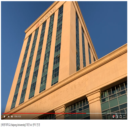

In [27]:
image_query = X_test[check_index].view(1,-1)
label_query = Y_test[check_index].view(1)
X_total= torch.cat([X_train, image_query], dim=0)
Y_total= torch.cat([Y_train, label_query], dim=0)

test_img = Function.to_pil_image(test_image[check_index])
print('Test image : {}'.format(test_label[check_index].item()))
display(test_img)

In [28]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_total.cpu().detach().numpy())

pairwise_dist_t = _pairwise_distance(X_total)
pairwise_dist_n = pairwise_dist_t.cpu().detach().numpy()

pairwise_dist_sort = np.sort(pairwise_dist_n[-1][:-1])

Query image : 0



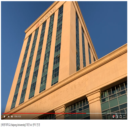



1 second similar 142 second image : 


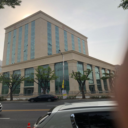



2 second similar 48 second image : 


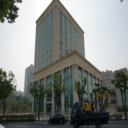



3 second similar 47 second image : 


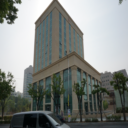



4 second similar 143 second image : 


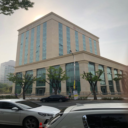



5 second similar 131 second image : 


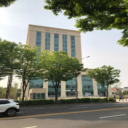

In [29]:
test_img = Function.to_pil_image(test_image[check_index])
print('Query image : {}\n'.format(test_label[check_index].item()))
display(test_img)
print("\n")

for ii in range(5):
  idx = np.where( pairwise_dist_n[-1] == pairwise_dist_sort[ii])
  print('{} second similar {} second image : '.format(ii+1,idx[0][0]))
  img = Function.to_pil_image(bef_train_image[idx[0][0]])
  #     img.save('test{}_{}.png'.format(Y_total[ii],ii))
  display(img)
  print("\n")

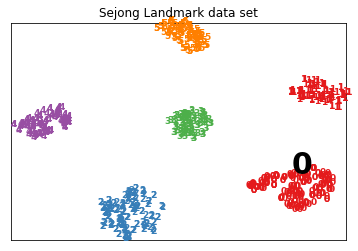

In [30]:
plot_embedding(X_tsne, Y_total,"Sejong Landmark data set")
plt.show()

In [31]:
X_tsne.shape

(777, 2)